## 1번
* 데이터 셋에서 주어진 특징들을 선택하여 CPU 성능 즉, “PRP” 변수를 예측하는 LinearRegression 기반 다중 선형 회귀 모델링을 프로그래밍 하시오.
- 데이터 탐색 및 시각화, 전처리, 훈련 데이터와 테스트 데이터 분리, 훈련 데이터 학습과정, 교차 검증, 분석 결과 시각화 등을 포함하여 최적화하는 전체 과정을 포함하시오.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB
None
(209, 10)
PRP                    1.000000
ERP                    0.966472
MMAX                   0.863004
MMIN                   0.794931
CACH                   0.662641
                         ...   
mname_v8655            0.002430
mname_as/6650          0.002324
mname_50-850-ii        0.001460
mname_as/7000-n        0.000269
mname_cyber:170/835    0.0001

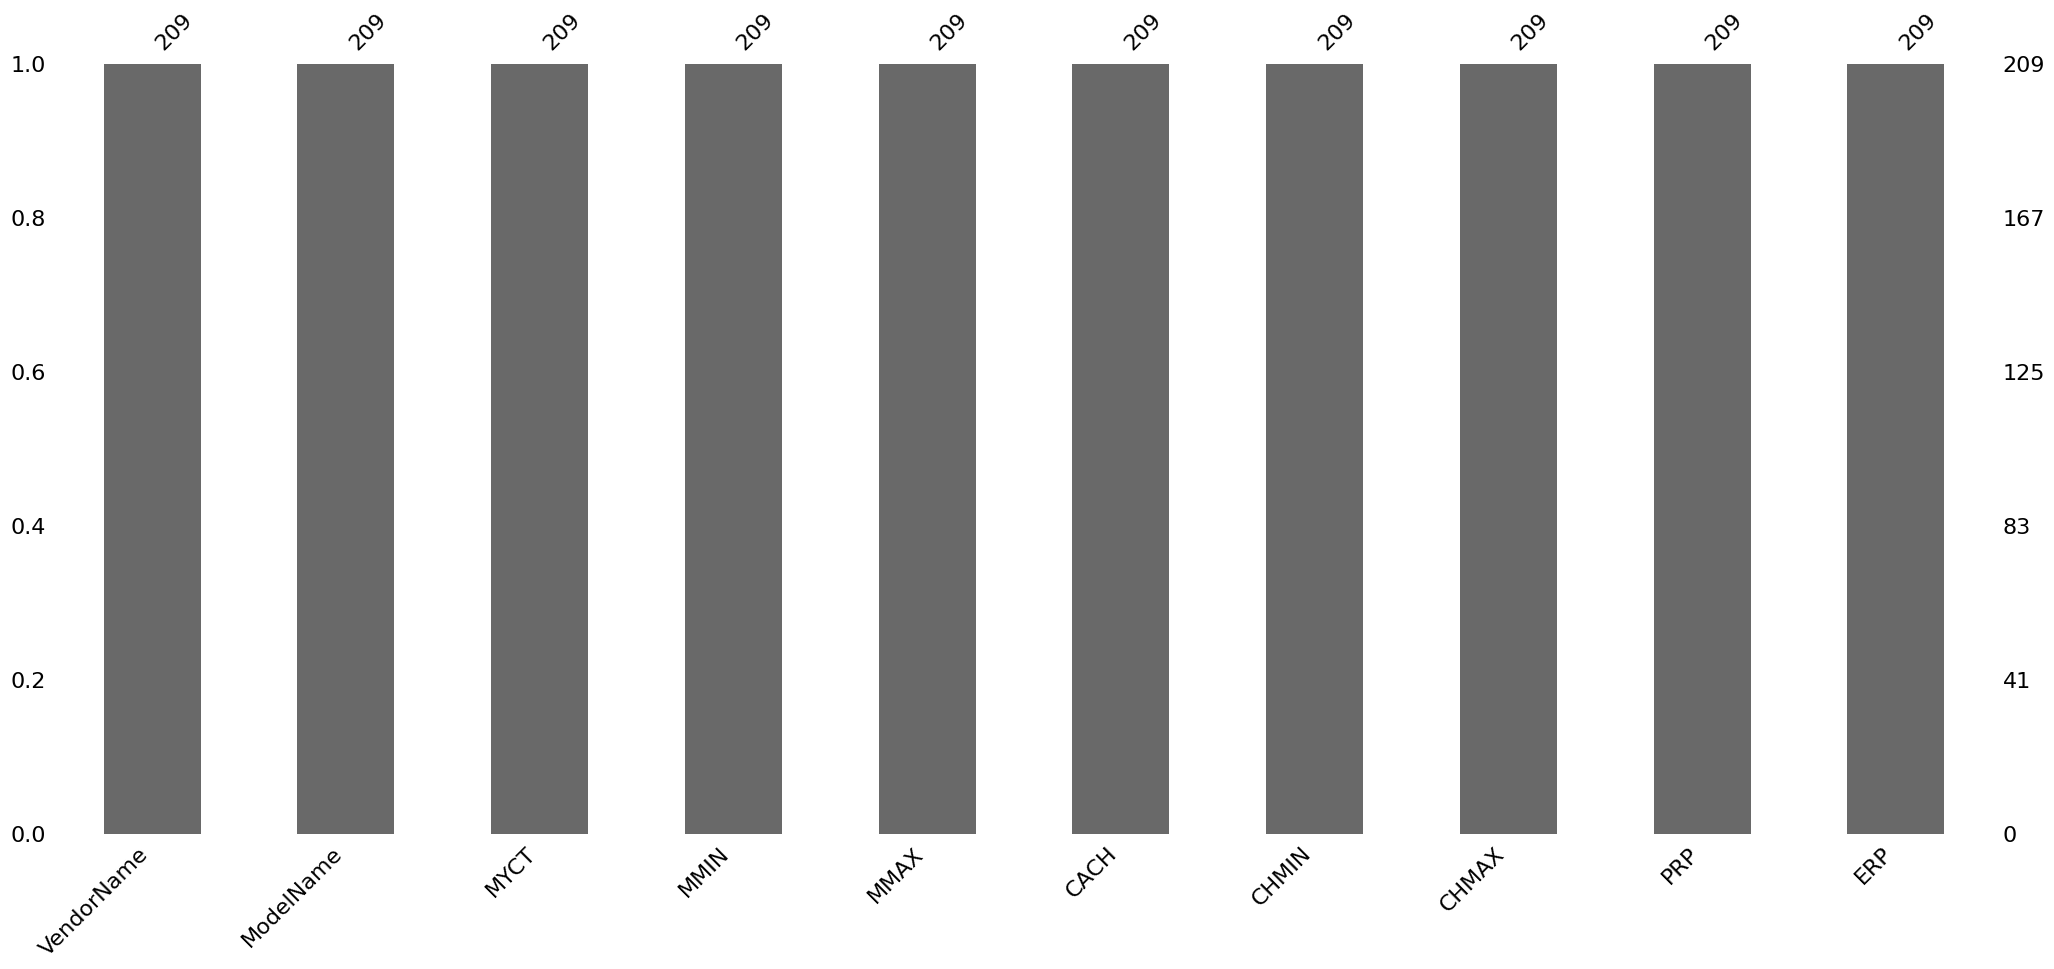

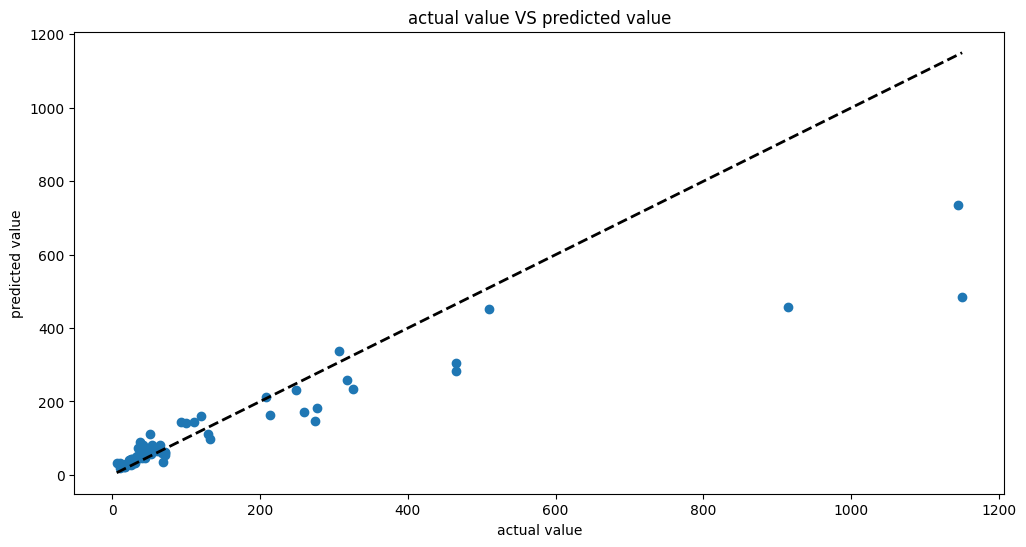

<Axes: xlabel='PRP', ylabel='Count'>

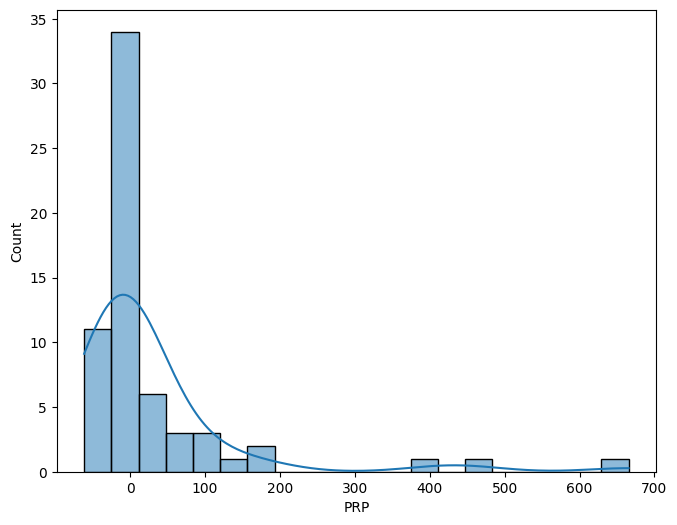

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import matplotlib.pyplot as plt

# 데이터 로드 및 탐색
db_model = pd.read_csv("machine.data_update.csv")  # 데이터셋을 CSV 파일로부터 로드
print(db_model.info())  # 데이터셋 정보 출력 (컬럼, 데이터 타입, 결측치 등)
print(db_model.shape)  # 데이터셋의 차원 (행, 열) 출력
msn.bar(db_model)  # 결측치 시각화

# 결측치 제거
db_model.dropna(inplace=True)  # 결측치가 있는 행 제거

# 전처리
db_dummie = pd.get_dummies(db_model.VendorName, prefix='vname', dtype=float)  # VendorName 컬럼을 더미 변수로 변환
db_model = pd.concat([db_model.drop("VendorName", axis=1), db_dummie], axis=1)  # 기존 VendorName 컬럼을 삭제하고 더미 변수 추가

db_dummie = pd.get_dummies(db_model["ModelName"], prefix='mname', dtype=float)  # ModelName 컬럼을 더미 변수로 변환
db_model = pd.concat([db_model.drop("ModelName", axis=1), db_dummie], axis=1)  # 기존 ModelName 컬럼을 삭제하고 더미 변수 추가

db_model.head()  # 데이터셋의 첫 5개 행 출력

# PRP와 다른 변수 간의 상관관계 확인
corr_PRP = db_model.corr()["PRP"]  # PRP와 각 변수 간의 상관계수를 계산
corr_PRP = np.abs(corr_PRP)  # 상관계수의 절대값을 취함
print(corr_PRP.sort_values(ascending=False))  # 상관계수를 내림차순으로 정렬하여 출력

# 테스트/훈련 데이터 나누기
x = db_model.drop(columns=["PRP"])  # PRP를 제외한 모든 컬럼을 입력 변수로 설정
y = db_model["PRP"]  # PRP 컬럼을 출력 변수로 설정
x.shape, y.shape  # 입력 변수와 출력 변수의 차원 출력

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)  # 데이터를 훈련용과 테스트용으로 분리 (30%를 테스트용)

scaler = StandardScaler()  # StandardScaler 객체 생성
x_train_sc = scaler.fit_transform(x_train)  # 훈련 데이터에 대해 표준화 스케일링 적용
x_test_sc = scaler.transform(x_test)  # 테스트 데이터에 대해 동일한 스케일링 적용

# 모델 훈련
model = LinearRegression()  # LinearRegression 모델 객체 생성
model.fit(x_train_sc, y_train)  # 훈련 데이터를 사용하여 모델 훈련

# 교차 검증 결과 계산
CVS_mse = cross_val_score(model, x_train_sc, y_train, cv=5, scoring="neg_mean_squared_error")  # 5-폴드 교차 검증을 통해 음의 MSE 계산
CVS_mse = -CVS_mse.mean()  # 음의 MSE를 양의 MSE로 변환하여 평균 계산
print("교차검증 결과:", CVS_mse)  # 교차 검증 결과 출력

# 모델 성능 평가
y_test_pred = model.predict(x_test_sc)  # 테스트 데이터에 대한 예측값 계산

# 시각화
plt.figure(figsize=(12, 6))  # 그래프 크기 설정
plt.scatter(y_test, y_test_pred)  # 실제값과 예측값의 산점도
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # 대각선 기준선
plt.xlabel('actual value')  # x축 라벨
plt.ylabel('predicted value')  # y축 라벨
plt.title('actual value VS predicted value')  # 그래프 제목
plt.show()  # 그래프 출력

plt.figure(figsize=(17, 6))  # 그래프 크기 설정
plt.subplot(1, 2, 1)  # 1행 2열 서브플롯의 첫 번째 그래프
resi = y_test - y_test_pred  # 잔차 계산 (실제값 - 예측값)
sns.histplot(resi, bins=20, kde=True)  # 잔차의 히스토그램과 커널 밀도 추정 그래프

## 2번
* (1) 단계에서 얻은 다중 선형 회귀 모델을 사용하여 학습 데이터와 테스트 데이터 각각에 대해 이 모델의 성능을 평가하시오. 
- Mean squared Error, Mean absolute Error, R^2, 교차검증

In [2]:
# 교차 검증을 통해 음의 MSE 계산 (훈련 데이터, 5-폴드 교차 검증)
CVS_mse = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_squared_error")
CVS_mse = -CVS_mse.mean()  # 음의 MSE를 양의 MSE로 변환하여 평균 계산

# 교차 검증을 통해 음의 MAE 계산 (훈련 데이터, 5-폴드 교차 검증)
CVS_mae = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_absolute_error")
CVS_mae = -CVS_mae.mean()  # 음의 MAE를 양의 MAE로 변환하여 평균 계산

# 교차 검증을 통해 R^2 계산 (훈련 데이터, 5-폴드 교차 검증)
CVS_r2 = cross_val_score(model, x_train, y_train, cv=5, scoring="r2")
CVS_r2 = CVS_r2.mean()  # R^2의 평균 계산
print(f"교차검증 결과 mse:{CVS_mse},mae:{CVS_mae},r2:{CVS_r2}")  # 교차 검증 결과 출력

# 훈련 데이터에 대한 예측값 계산
y_pred = model.predict(x_train_sc)

# 훈련 데이터에 대한 R^2 계산
r2_train = r2_score(y_train, y_pred)
# 훈련 데이터에 대한 MSE 계산
mse_train = mean_squared_error(y_train, y_pred)
# 훈련 데이터에 대한 MAE 계산
mae_train = mean_absolute_error(y_train, y_pred)

# 훈련 데이터 검증 결과 출력
print(f"훈련데이터 검증 r2:{r2_train},mse:{mse_train},mae:{mae_train}")

# 테스트 데이터에 대한 예측값 계산
y_test_pred = model.predict(x_test_sc)

# 테스트 데이터에 대한 R^2 계산
r2_test = r2_score(y_test, y_test_pred)
# 테스트 데이터에 대한 MSE 계산
mse_test = mean_squared_error(y_test, y_test_pred)
# 테스트 데이터에 대한 MAE 계산
mae_test = mean_absolute_error(y_test, y_test_pred)

# 훈련 데이터에 대한 모델 점수 계산
score = model.score(x_train_sc, y_train)

# 테스트 데이터 검증 결과 출력
print(f"테스트 데이터 검증 r2:{r2_test},mse:{mse_test},mae:{mae_test},스코어:{score}")

# 결과를 데이터프레임으로 정리
df = pd.DataFrame({'Model': ['Linear Regression', 'Linear Regression', 'Linear Regression'],
                   'Data': ['Train', 'Test', 'Cross Validation'],
                   'MSE': [mse_train, mse_test, CVS_mse],
                   'MAE': [mae_train, mae_test, CVS_mae],
                   'R^2': [r2_train, r2_test, CVS_r2]})
print(df)  # 결과 데이터프레임 출력

# 결과를 CSV 파일로 저장
df.to_csv('result_db_model.csv', index=False)

교차검증 결과 mse:1808.5623314075547,mae:24.176119384598216,r2:0.7202709323787005
훈련데이터 검증 r2:1.0,mse:3.09575818866875e-26,mae:1.1602286863370404e-13
테스트 데이터 검증 r2:0.7351595444987953,mse:15164.976407745187,mae:53.697112651550086,스코어:1.0
               Model              Data           MSE           MAE       R^2
0  Linear Regression             Train  3.095758e-26  1.160229e-13  1.000000
1  Linear Regression              Test  1.516498e+04  5.369711e+01  0.735160
2  Linear Regression  Cross Validation  1.808562e+03  2.417612e+01  0.720271


## 3번
* (2) 단계에서 얻은 모델의 테스트 데이터에 대해 R^2가 90% 이상이 나오도록 모델을 개선하시오.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   VendorName  209 non-null    object
 1   ModelName   209 non-null    object
 2   MYCT        209 non-null    int64 
 3   MMIN        209 non-null    int64 
 4   MMAX        209 non-null    int64 
 5   CACH        209 non-null    int64 
 6   CHMIN       209 non-null    int64 
 7   CHMAX       209 non-null    int64 
 8   PRP         209 non-null    int64 
 9   ERP         209 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 16.5+ KB
None
(209, 10)
PRP                    1.000000
ERP                    0.966472
MMAX                   0.863004
MMIN                   0.794931
CACH                   0.662641
                         ...   
mname_v8655            0.002430
mname_as/6650          0.002324
mname_50-850-ii        0.001460
mname_as/7000-n        0.000269
mname_cyber:170/835    0.0001

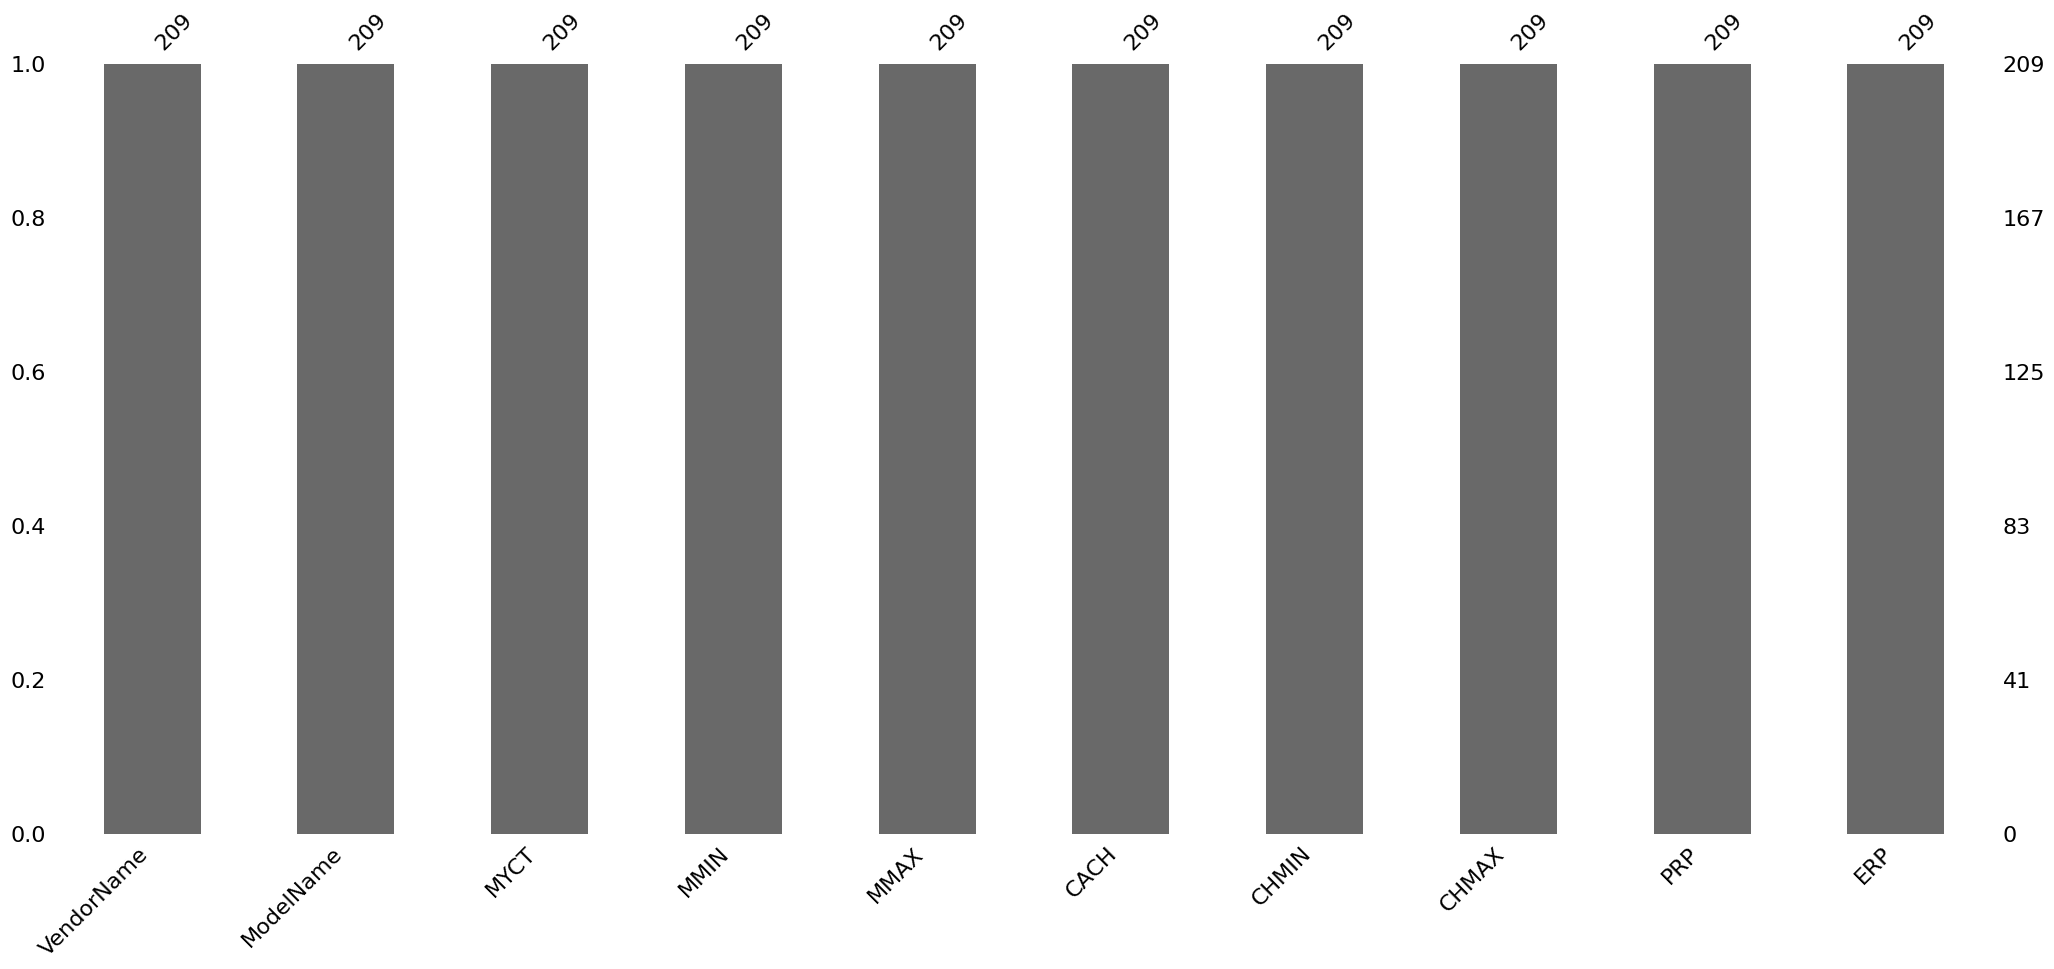

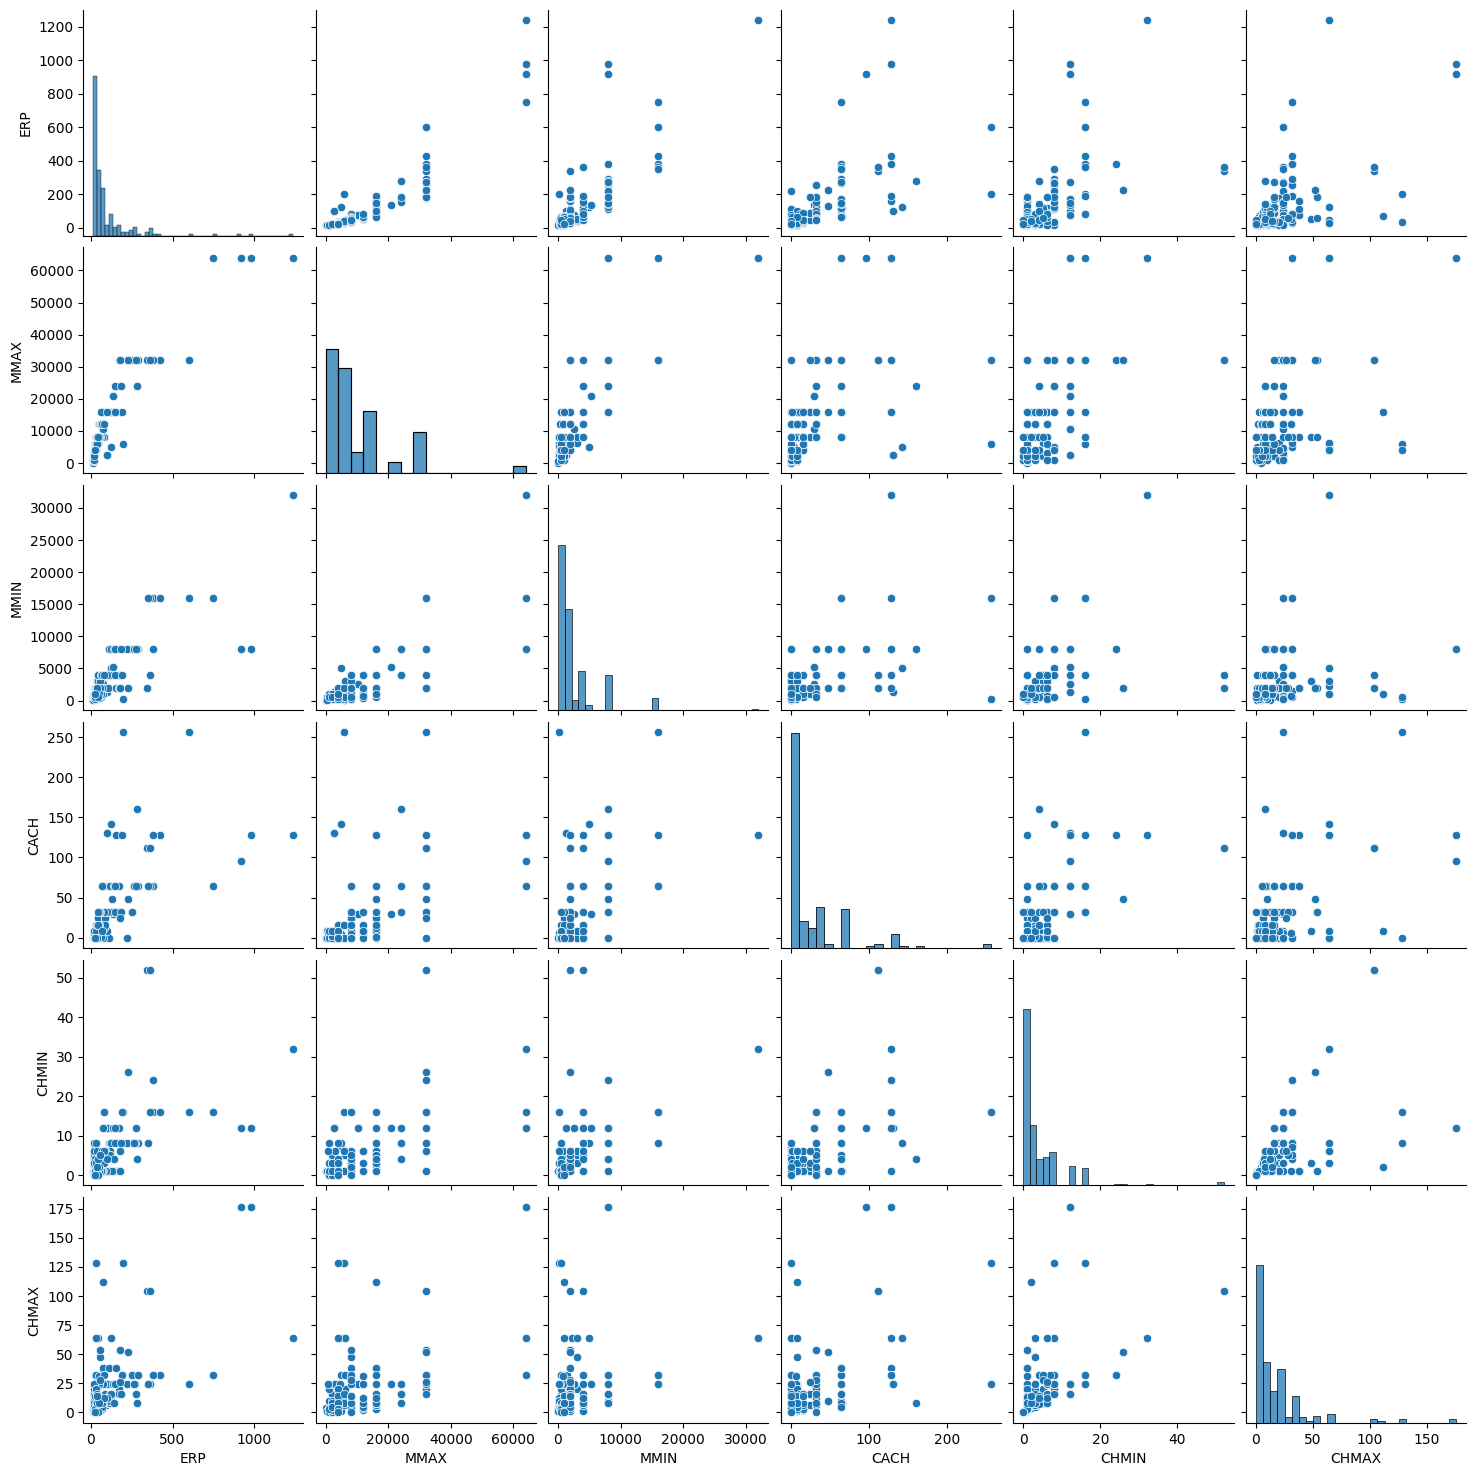

교차검증 결과- mse:3171.7814689588477, mae:30.708239104233986, r2:0.7000356757368549
훈련데이터 검증- r2:0.9329927675202943, mse:1641.5310001550733, mae:24.442695498734405
테스트 데이터 검증- r2:0.9352616245328073, mse:1850.7451144492338, mae:23.545204839268898, 스코어:0.9329927675202943
               Model              Data          MSE        MAE       R^2
0  Linear Regression             Train  1641.531000  24.442695  0.932993
1  Linear Regression              Test  1850.745114  23.545205  0.935262
2  Linear Regression  Cross Validation  3171.781469  30.708239  0.700036


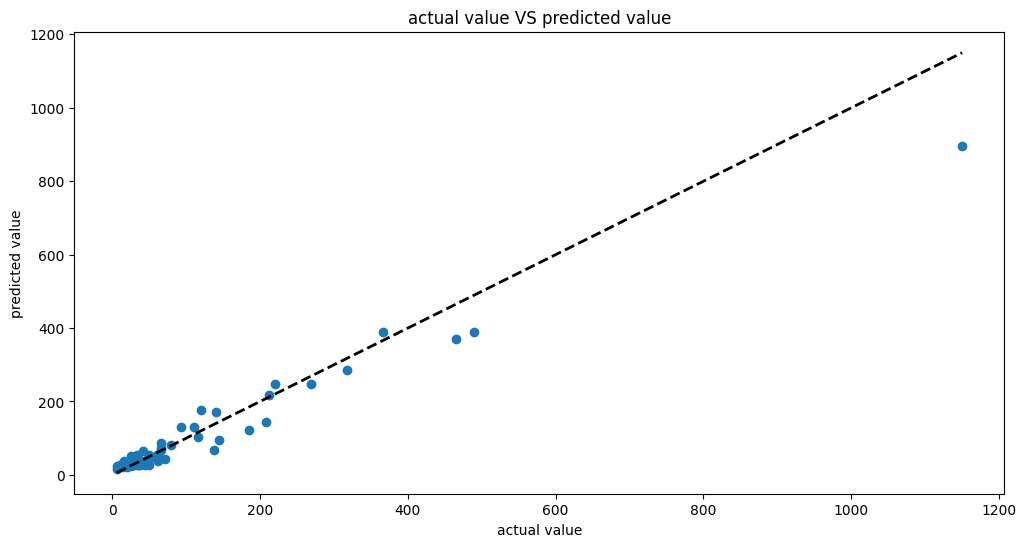

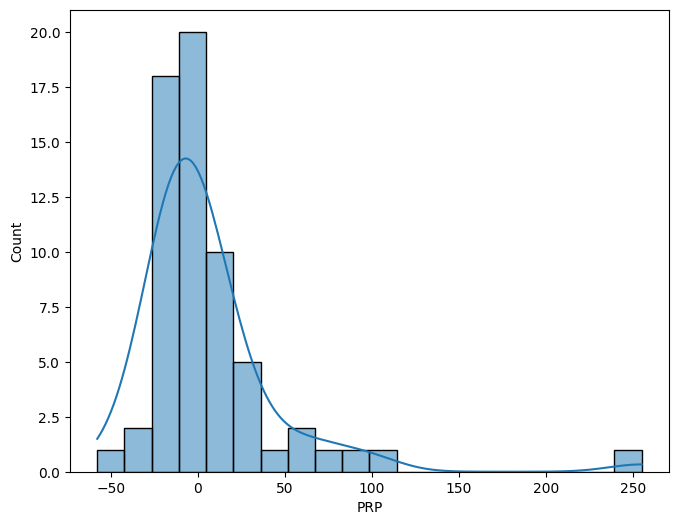

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt

# 데이터 로드 및 탐색
db_model = pd.read_csv("machine.data_update.csv")  # CSV 파일로부터 데이터셋 로드
print(db_model.info())  # 데이터셋 정보 출력 (컬럼, 데이터 타입, 결측치 등)
print(db_model.shape)  # 데이터셋의 차원 (행, 열) 출력
msn.bar(db_model)  # 결측치 시각화
db_model.dropna(inplace=True)  # 결측치가 있는 행 제거

# 전처리
db_dummie = pd.get_dummies(db_model.VendorName, prefix='vname', dtype=float)  # VendorName 컬럼을 더미 변수로 변환
db_model = pd.concat([db_model.drop("VendorName", axis=1), db_dummie], axis=1)  # 기존 VendorName 컬럼을 삭제하고 더미 변수 추가

db_dummie = pd.get_dummies(db_model["ModelName"], prefix='mname', dtype=float)  # ModelName 컬럼을 더미 변수로 변환
db_model = pd.concat([db_model.drop("ModelName", axis=1), db_dummie], axis=1)  # 기존 ModelName 컬럼을 삭제하고 더미 변수 추가
db_model.head()  # 데이터셋의 첫 5개 행 출력

# PRP와 다른 변수 간의 상관관계 확인
corr_PRP = db_model.corr()["PRP"]  # PRP와 각 변수 간의 상관계수 계산
corr_PRP = np.abs(corr_PRP)  # 상관계수의 절대값을 취함
print(corr_PRP.sort_values(ascending=False))  # 상관계수를 내림차순으로 정렬하여 출력

# 시각화
Number_feat = ['ERP', 'MMAX', 'MMIN', 'CACH', 'CHMIN', 'CHMAX']  # 관심있는 숫자형 변수 리스트
sns.pairplot(db_model[Number_feat])  # 변수들 간의 관계를 시각화
plt.show()  # 그래프 출력

# 테스트/훈련 데이터 나누기
x = db_model[Number_feat]  # 입력 변수 설정 (관심있는 숫자형 변수)
y = db_model["PRP"]  # 출력 변수 설정 (PRP)
x.shape, y.shape  # 입력 변수와 출력 변수의 차원 출력

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10)  # 데이터를 훈련용과 테스트용으로 분리 (30%를 테스트용)

scaler = StandardScaler()  # StandardScaler 객체 생성
x_train_sc = scaler.fit_transform(x_train)  # 훈련 데이터에 대해 표준화 스케일링 적용
x_test_sc = scaler.transform(x_test)  # 테스트 데이터에 대해 동일한 스케일링 적용

# 모델 훈련
model = LinearRegression()  # LinearRegression 모델 객체 생성
model.fit(x_train_sc, y_train)  # 훈련 데이터를 사용하여 모델 훈련

# 교차 검증 결과 계산
y_test_pred = model.predict(x_test_sc)  # 테스트 데이터에 대한 예측값 계산
CVS_mse = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_squared_error")  # 5-폴드 교차 검증을 통해 음의 MSE 계산
CVS_mse = -CVS_mse.mean()  # 음의 MSE를 양의 MSE로 변환하여 평균 계산

CVS_mae = cross_val_score(model, x_train, y_train, cv=5, scoring="neg_mean_absolute_error")  # 5-폴드 교차 검증을 통해 음의 MAE 계산
CVS_mae = -CVS_mae.mean()  # 음의 MAE를 양의 MAE로 변환하여 평균 계산

CVS_r2 = cross_val_score(model, x_train, y_train, cv=5, scoring="r2")  # 5-폴드 교차 검증을 통해 R^2 계산
CVS_r2 = CVS_r2.mean()  # R^2의 평균 계산
print(f"교차검증 결과- mse:{CVS_mse}, mae:{CVS_mae}, r2:{CVS_r2}")  # 교차 검증 결과 출력

# 훈련 데이터 성능 평가
y_pred = model.predict(x_train_sc)  # 훈련 데이터에 대한 예측값 계산
r2_train = r2_score(y_train, y_pred)  # 훈련 데이터에 대한 R^2 계산
mse_train = mean_squared_error(y_train, y_pred)  # 훈련 데이터에 대한 MSE 계산
mae_train = mean_absolute_error(y_train, y_pred)  # 훈련 데이터에 대한 MAE 계산
print(f"훈련데이터 검증- r2:{r2_train}, mse:{mse_train}, mae:{mae_train}")  # 훈련 데이터 검증 결과 출력

# 테스트 데이터 성능 평가
y_test_pred = model.predict(x_test_sc)  # 테스트 데이터에 대한 예측값 계산
r2_test = r2_score(y_test, y_test_pred)  # 테스트 데이터에 대한 R^2 계산
mse_test = mean_squared_error(y_test, y_test_pred)  # 테스트 데이터에 대한 MSE 계산
mae_test = mean_absolute_error(y_test, y_test_pred)  # 테스트 데이터에 대한 MAE 계산
score = model.score(x_train_sc, y_train)  # 훈련 데이터에 대한 모델 점수 계산
print(f"테스트 데이터 검증- r2:{r2_test}, mse:{mse_test}, mae:{mae_test}, 스코어:{score}")  # 테스트 데이터 검증 결과 출력

# 결과를 데이터프레임으로 정리
df = pd.DataFrame({'Model': ['Linear Regression', 'Linear Regression', 'Linear Regression'],
                   'Data': ['Train', 'Test', 'Cross Validation'],
                   'MSE': [mse_train, mse_test, CVS_mse],
                   'MAE': [mae_train, mae_test, CVS_mae],
                   'R^2': [r2_train, r2_test, CVS_r2]})
print(df)  # 결과 데이터프레임 출력

# 결과를 CSV 파일로 저장
df.to_csv('result_db_model.csv', index=False)

# 시각화
plt.figure(figsize=(12, 6))  # 그래프 크기 설정
plt.scatter(y_test, y_test_pred)  # 실제값과 예측값의 산점도
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # 대각선 기준선
plt.xlabel('actual value')  # x축 라벨
plt.ylabel('predicted value')  # y축 라벨
plt.title('actual value VS predicted value')  # 그래프 제목
plt.show()  # 그래프 출력

plt.figure(figsize=(17, 6))  # 그래프 크기 설정
plt.subplot(1, 2, 1)  # 1행 2열 서브플롯의 첫 번째 그래프
resi = y_test - y_test_pred  # 잔차 계산 (실제값 - 예측값)
sns.histplot(resi, bins=20, kde=True)  # 잔차의 히스토그램과 커널 밀도 추정 그래프
x_train_df = pd.DataFrame(x_train_sc, columns=Number_feat)  # 스케일링된 훈련 데이터를 데이터프레임으로 변환